In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import io
from google.colab import files
uploaded = files.upload()
dfs = {}
for item in uploaded:
  dfs[item.split('.')[0]] = pd.read_csv(io.BytesIO(uploaded[item]))

Saving 2016_Denver_df.csv to 2016_Denver_df.csv


In [3]:
df = dfs['2016_Denver_df'].copy()
date_time = df.pop('Date and Time')
df.index = date_time

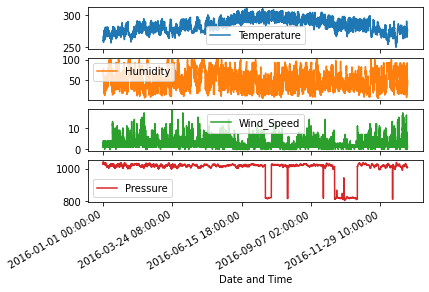

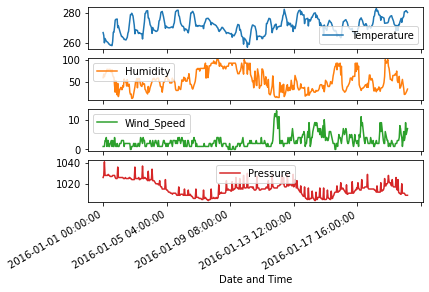

In [4]:
plot_cols = ['Temperature','Humidity','Wind_Speed','Pressure']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots = True)

In [5]:
numeric_features = [
    'Humidity',
    'Pressure',
    'Temperature',
    'Wind_Speed'
]
for feature in numeric_features:
  pd.to_numeric(df[feature])
df = df[numeric_features]
normal_df = df.copy()
num_features = len(numeric_features)

In [6]:
column_indices = {name: i for i, name in enumerate(numeric_features)}
column_indices

{'Humidity': 0, 'Pressure': 1, 'Temperature': 2, 'Wind_Speed': 3}

In [7]:
train_df = df.iloc[0:6500][numeric_features].copy()[['Humidity','Pressure','Temperature','Wind_Speed']]
val_df = df.iloc[6501:7200][numeric_features].copy()[['Humidity','Pressure','Temperature','Wind_Speed']]
test_df = df.iloc[7201:][numeric_features].copy()[['Humidity','Pressure','Temperature','Wind_Speed']]
predict_df = normal_df.tail(24)

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

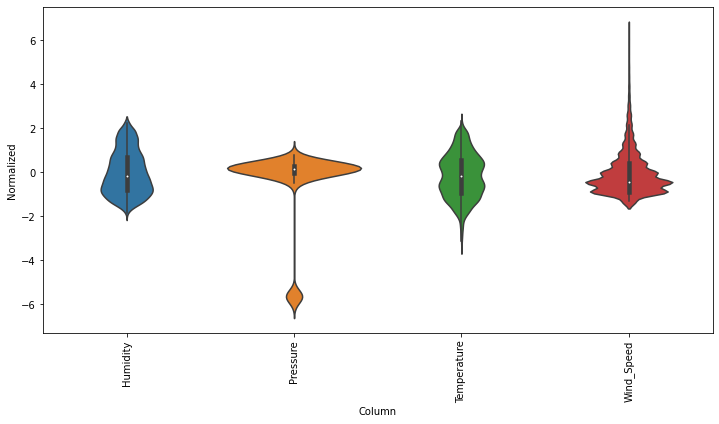

In [9]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [44]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df, predict_df = predict_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.predictions = None

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [45]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis = -1)
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [46]:
def plot(self, model = None, plot_col = 'Temperature', max_subplots = 3):
  inputs, labels = self.example
  plt.figure(figsize = (12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label = 'Inputs', marker = '.', zorder = -10)
    
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    
    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors = 'k', label = 'Labels', c = '#2ca02c', s = 64)
    if model is not None:
      predictions = model(inputs)
      self.predictions = predictions
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker = 'X', edgecolors = 'k', label = 'Predictions',
                  c = '#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [47]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [48]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [49]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index = None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [50]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [51]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 4)
Labels shape (batch, time, features): (32, 24, 4)


In [52]:
baseline = Baseline()
baseline.compile(loss = tf.losses.MeanSquaredError(),
                 metrics = [tf.metrics.MeanAbsoluteError()])

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

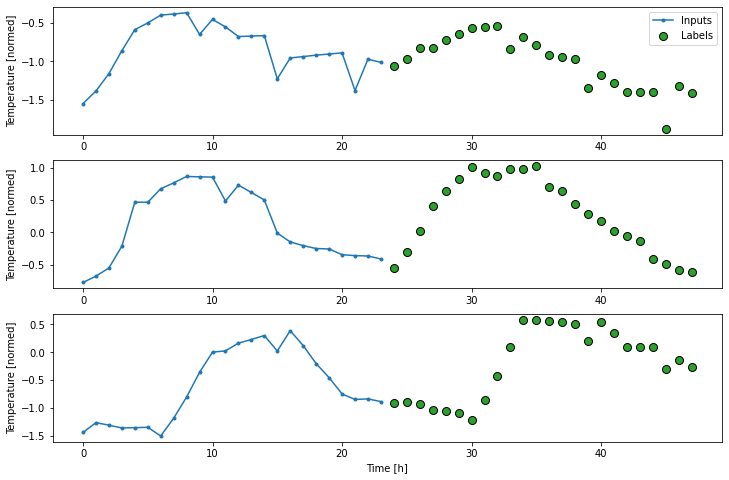

In [53]:
OUT_STEPS = 24
# `WindowGenerator` returns all features as labels if you 
# don't set the `label_columns` argument.
multi_window = WindowGenerator(input_width = 24,
                               label_width = OUT_STEPS,
                               shift = OUT_STEPS)

multi_window.plot()
multi_window

In [54]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics = [tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose = 0)

21/21 [==============================] - 0s 3ms/step - loss: 0.7323 - mean_absolute_error: 0.5349


21/21 [==============================] - 0s 2ms/step - loss: 0.6567 - mean_absolute_error: 0.4300


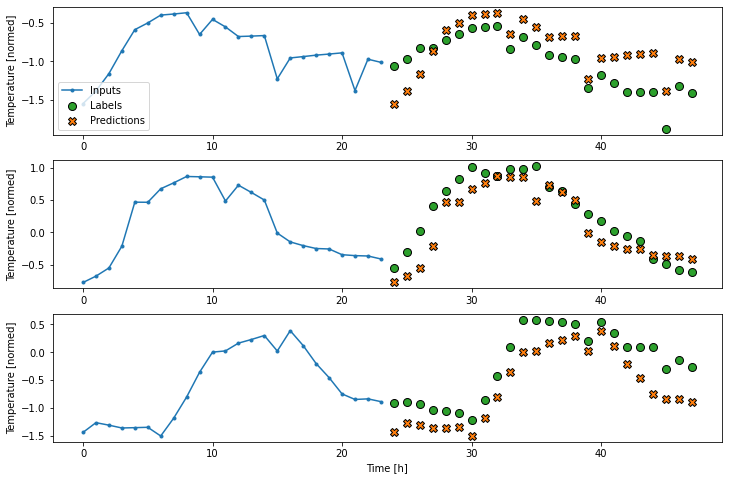

In [55]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss = tf. losses.MeanSquaredError(),
                        metrics = [tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose = 0)
multi_window.plot(repeat_baseline)

**--------RNN--------**

In [56]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [57]:
feedback_model = FeedBack(units = 32, out_steps = OUT_STEPS)

In [58]:
def warmup(self,inputs):
  #inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  #predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state 

FeedBack.warmup = warmup

In [59]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 4])

In [60]:
def call(self, inputs, training = None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input
    x = prediction
    # Execute on lstm step
    x, state = self.lstm_cell(x, states = state,
                              training = training)
    # Convert the lstm output to a prediction
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  #predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1,0,2])
  return predictions

FeedBack.call = call

In [61]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 4)


21/21 [==============================] - 0s 5ms/step - loss: 1.0441 - mean_absolute_error: 0.6819


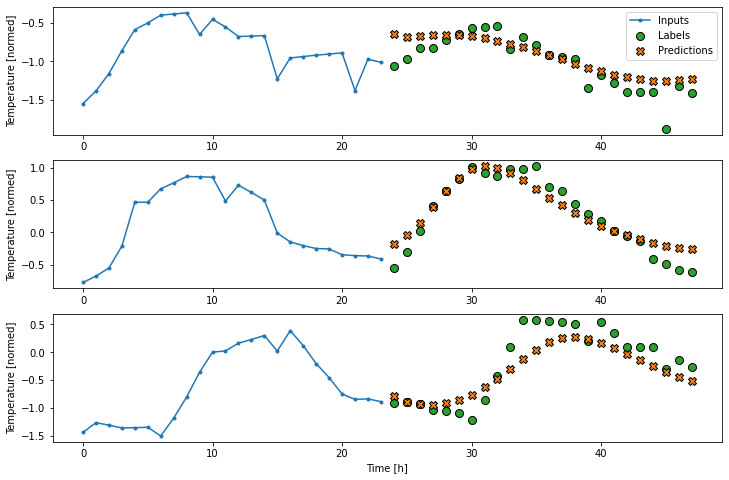

In [62]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
multi_window.plot(feedback_model)

In [71]:
prediction_set = predict_df.to_numpy()[np.newaxis,:]
prediction_set

array([[[1.3000e+01, 1.0050e+03, 2.8736e+02, 3.0000e+00],
        [2.2000e+01, 1.0060e+03, 2.8421e+02, 3.0000e+00],
        [1.7000e+01, 1.0050e+03, 2.8336e+02, 2.0000e+00],
        [1.4000e+01, 1.0050e+03, 2.8233e+02, 2.0000e+00],
        [2.7000e+01, 1.0060e+03, 2.7778e+02, 2.0000e+00],
        [3.9000e+01, 1.0060e+03, 2.7648e+02, 1.0000e+00],
        [1.6000e+01, 1.0060e+03, 2.7966e+02, 8.0000e+00],
        [2.0000e+01, 1.0060e+03, 2.7853e+02, 2.0000e+00],
        [1.6000e+01, 1.0070e+03, 2.7726e+02, 1.0000e+00],
        [7.4000e+01, 1.0090e+03, 2.7057e+02, 5.0000e+00],
        [7.9000e+01, 1.0110e+03, 2.7001e+02, 4.0000e+00],
        [7.9000e+01, 1.0120e+03, 2.6872e+02, 0.0000e+00],
        [7.9000e+01, 1.0110e+03, 2.6828e+02, 1.0000e+00],
        [9.2000e+01, 1.0100e+03, 2.6787e+02, 0.0000e+00],
        [8.5000e+01, 1.0090e+03, 2.6877e+02, 4.0000e+00],
        [8.5000e+01, 1.0080e+03, 2.6598e+02, 7.0000e+00],
        [6.8000e+01, 1.0080e+03, 2.6915e+02, 3.0000e+00],
        [5.800

In [72]:
feedback_model.predict(prediction_set)

array([[[ 0.01504521, -0.11153757, -0.9326217 , -0.657027  ],
        [ 0.6262846 ,  0.09900913, -0.7388168 , -0.0391757 ],
        [ 0.75472146,  0.12963027, -0.61599123, -0.14498492],
        [ 0.92838544,  0.15401322, -0.6194305 , -0.20680214],
        [ 1.0781326 ,  0.16121021, -0.60447043, -0.26429173],
        [ 1.2096249 ,  0.16421762, -0.6031237 , -0.31478328],
        [ 1.3268952 ,  0.17594466, -0.6047787 , -0.36682016],
        [ 1.4513562 ,  0.22429988, -0.60223866, -0.43863997],
        [ 1.6038538 ,  0.3084373 , -0.58417976, -0.5351721 ],
        [ 1.7813097 ,  0.39306533, -0.55834603, -0.6318326 ],
        [ 1.9629455 ,  0.45384324, -0.5394704 , -0.70968056],
        [ 2.1270142 ,  0.48785502, -0.5328726 , -0.766515  ],
        [ 2.2585084 ,  0.5002029 , -0.5355223 , -0.8047997 ],
        [ 2.3500996 ,  0.49665564, -0.5413007 , -0.8264017 ],
        [ 2.4003813 ,  0.4825759 , -0.5446823 , -0.8321489 ],
        [ 2.411097  ,  0.4629041 , -0.5419835 , -0.82220006],
        

In [66]:
predicts = (multi_window.predictions)
for arr in predicts:
  

<tf.Tensor: shape=(32, 24, 4), dtype=float32, numpy=
array([[[-0.8730215 ,  0.08287811, -0.6436204 ,  0.99241555],
        [-0.8776933 ,  0.08463427, -0.68229026,  1.043076  ],
        [-0.8868286 ,  0.0892873 , -0.67233056,  1.0969416 ],
        ...,
        [ 0.11525097,  0.06930172, -1.2526526 ,  0.5880867 ],
        [ 0.13400427,  0.05321916, -1.2443597 ,  0.5954889 ],
        [ 0.13906375,  0.03613325, -1.2243235 ,  0.60911417]],

       [[ 0.34501335,  0.19850108, -0.17975053, -0.17994499],
        [ 0.13443893,  0.14897779, -0.04657061, -0.11865535],
        [-0.1120283 ,  0.12644514,  0.14843817, -0.06769423],
        ...,
        [ 0.5277405 ,  0.24786997, -0.20629318, -0.153824  ],
        [ 0.55046725,  0.25394738, -0.24073604, -0.14565703],
        [ 0.5344164 ,  0.25529504, -0.25222966, -0.11523993]],

       [[-0.42809466,  0.35197306, -0.78121305, -0.13644494],
        [-0.3841419 ,  0.33765092, -0.8879033 , -0.13294265],
        [-0.35205862,  0.34039634, -0.93080324, -

In [31]:
predict_df

,Humidity,Pressure,Temperature,Wind_Speed
Date and Time,,,,
2016-12-31 00:00:00,13.0,1005.0,287.36,3.0
2016-12-31 01:00:00,22.0,1006.0,284.21,3.0
2016-12-31 02:00:00,17.0,1005.0,283.36,2.0
2016-12-31 03:00:00,14.0,1005.0,282.33,2.0
2016-12-31 04:00:00,27.0,1006.0,277.78,2.0
2016-12-31 05:00:00,39.0,1006.0,276.48,1.0
2016-12-31 06:00:00,16.0,1006.0,279.66,8.0
2016-12-31 07:00:00,20.0,1006.0,278.53,2.0
2016-12-31 08:00:00,16.0,1007.0,277.26,1.0



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



ValueError: ignored